<a href="https://colab.research.google.com/github/poonamaswani/DataScienceAndAI/blob/main/CAM_DS_C101_Demo_5_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**First things first** - please go to 'File' and select 'Save a copy in Drive' so that you have your own version of this activity set up and ready to use.
Remember to update the portfolio index link to your own work once completed!

# Demonstration 5.1.3 Detecting anomalies with IQR

The Pronto Cycle Share, branded as Pronto!, was a public bicycle sharing system in Seattle, Washington (USA) that operated from 2014 to 2017. Pronto! had 500 bikes and 54 stations. In this demonstration, we'll explore the trip data set and employ IQR to perform anomaly detection. The data set contains the following information:
- `trip_id`: numeric ID of bike trip taken
- `starttime`: day and time trip started, in PST
- `stoptime`: day and time trip ended, in PST
- `bikeid`: ID attached to each bike
- `tripduration`: time of trip in seconds
- `from_station_name`: name of station where trip originated
- `to_station_name`: name of station where trip terminated
- `from_station_id`: ID of station where trip originated
- `to_station_id`: ID of station where trip terminated
- `usertype`: "Short-Term Pass Holder" is a rider who purchased a 24-Hour or 3-Day Pass; "Member" is a rider who purchased a Monthly or an Annual Membership
- `gender`: gender of rider
- `birthyear`: birth year of rider

Follow the demonstration to see how to perform anomaly detection with the IQR method.


## a. Original data set

In [ ]:
# Import the necessary libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import the data with a URL link from GitHub.
# Take note: The data is zipped, but Pandas supports zip file reads.
data = pd.read_csv('https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/trip.zip')

# Display the first few rows of the data set.
print(data.shape)
data.head()

(236065, 12)


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


In [ ]:
# Determine metadata of DataFrame.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236065 entries, 0 to 236064
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            236065 non-null  int64  
 1   starttime          236065 non-null  object 
 2   stoptime           236065 non-null  object 
 3   bikeid             236065 non-null  object 
 4   tripduration       236065 non-null  float64
 5   from_station_name  236065 non-null  object 
 6   to_station_name    236065 non-null  object 
 7   from_station_id    236065 non-null  object 
 8   to_station_id      236065 non-null  object 
 9   usertype           236065 non-null  object 
 10  gender             146171 non-null  object 
 11  birthyear          146167 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 21.6+ MB


In [ ]:
# Add a new colum to convert tripduration from seconds to minutes.
new_df = data.assign(total_time = data.tripduration / 60)

# View output.
new_df

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,total_time
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0,16.432250
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0,15.439583
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0,14.730517
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0,14.432283
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0,15.398717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236060,255241,8/31/2016 23:34,8/31/2016 23:45,SEA00201,679.532,Harvard Ave & E Pine St,2nd Ave & Spring St,CH-09,CBD-06,Short-Term Pass Holder,NaN,NaN,11.325533
236061,255242,8/31/2016 23:48,9/1/2016 0:20,SEA00247,1965.418,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN,32.756967
236062,255243,8/31/2016 23:47,9/1/2016 0:20,SEA00300,1951.173,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN,32.519550
236063,255244,8/31/2016 23:49,9/1/2016 0:20,SEA00047,1883.299,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN,31.388317


In [ ]:
# Compute descriptive statistics.
new_df['total_time'].describe().round(2)

count    236065.00
mean         20.04
std          34.44
min           1.00
25%           6.54
50%          10.55
75%          19.08
max         479.91
Name: total_time, dtype: float64

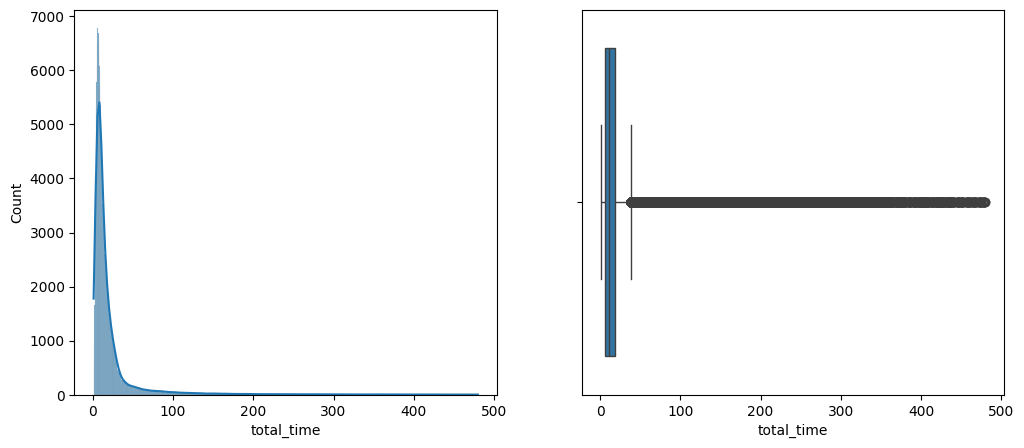

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualise data with histogram.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data = new_df['total_time'], kde = True)

plt.subplot(1, 2, 2)
sns.boxplot(x = new_df['total_time'])
plt.show()

plt.tight_layout()

In [ ]:
# Calculating IQR and identify any outliers.
# We are only interested in the tripduration column.
sorts = new_df['total_time'].sort_values()

# View output.
print(sorts.shape)
sorts

(236065,)


88286       1.000133
61229       1.001267
56705       1.001850
105967      1.004233
74218       1.004583
             ...    
12261     478.127083
12260     478.178750
103997    478.791350
181014    479.664400
112356    479.906633
Name: total_time, Length: 236065, dtype: float64

In [ ]:
# Calculate the quantiles.
q1 = sorts.quantile(0.25)
q3 = sorts.quantile(0.75)

# View the output.
print("The value of Q1 is:", q1)
print("The value of Q3 is:", q3)

# Compute and view the IQR.
iqr = q3 - q1
print("The value of IQR is:",iqr)

The value of Q1 is: 6.53775
The value of Q3 is: 19.083583333333333
The value of IQR is: 12.545833333333334


In [ ]:
# Filtering the outliers.
# 1. Calculate the upper and lower limits.
lower = q1-1.5*iqr
upper = q3+1.5*iqr

# View the limits.
print("Upper limit: ", upper)
print("Lower limit: ", lower)

Upper limit:  37.90233333333333
Lower limit:  -12.281000000000002


In [ ]:
# Filter out the anomalies more than the upper limit.
new_df[new_df['total_time'] > upper]

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,total_time
55,490,10/13/2014 11:54,10/13/2014 12:39,SEA00048,2676.788,E Harrison St & Broadway Ave E,Cal Anderson Park / 11th Ave & Pine St,CH-02,CH-08,Member,Male,1990.0,44.613133
56,492,10/13/2014 11:55,10/13/2014 12:39,SEA00214,2684.590,E Harrison St & Broadway Ave E,Cal Anderson Park / 11th Ave & Pine St,CH-02,CH-08,Member,Other,1981.0,44.743167
58,494,10/13/2014 11:58,10/13/2014 12:39,SEA00104,2444.973,E Harrison St & Broadway Ave E,Cal Anderson Park / 11th Ave & Pine St,CH-02,CH-08,Member,Other,1967.0,40.749550
60,497,10/13/2014 12:02,10/13/2014 12:40,SEA00438,2286.013,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,Children's Hospital / Sandpoint Way NE & 40th ...,UD-01,DPD-03,Member,Male,1955.0,38.100217
62,499,10/13/2014 12:02,10/13/2014 14:28,SEA00080,8737.446,Occidental Park / Occidental Ave S & S Washing...,3rd Ave & Broad St,PS-04,BT-01,Member,Male,1950.0,145.624100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235973,255152,8/31/2016 17:31,8/31/2016 22:54,SEA00091,19390.866,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,UD-01,UD-01,Short-Term Pass Holder,NaN,NaN,323.181100
235975,255154,8/31/2016 17:32,8/31/2016 22:54,SEA00026,19345.371,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,UD-01,UD-01,Short-Term Pass Holder,NaN,NaN,322.422850
235998,255178,8/31/2016 18:16,8/31/2016 18:55,SEA00219,2330.807,Key Arena / 1st Ave N & Harrison St,Seattle University / E Columbia St & 12th Ave,SLU-19,FH-04,Short-Term Pass Holder,NaN,NaN,38.846783
235999,255179,8/31/2016 18:16,8/31/2016 18:55,SEA00303,2328.735,Key Arena / 1st Ave N & Harrison St,Seattle University / E Columbia St & 12th Ave,SLU-19,FH-04,Short-Term Pass Holder,NaN,NaN,38.812250


In [ ]:
# Filter out the anomalies smaller than the lower limit.
new_df[new_df['total_time'] < lower]

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,total_time


In [ ]:
# View the original data without anomalies.
clean_data = new_df[new_df.total_time < upper]

# View output.
print(clean_data.shape)
clean_data

(213525, 13)


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,total_time
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0,16.432250
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0,15.439583
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0,14.730517
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0,14.432283
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0,15.398717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236060,255241,8/31/2016 23:34,8/31/2016 23:45,SEA00201,679.532,Harvard Ave & E Pine St,2nd Ave & Spring St,CH-09,CBD-06,Short-Term Pass Holder,NaN,NaN,11.325533
236061,255242,8/31/2016 23:48,9/1/2016 0:20,SEA00247,1965.418,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN,32.756967
236062,255243,8/31/2016 23:47,9/1/2016 0:20,SEA00300,1951.173,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN,32.519550
236063,255244,8/31/2016 23:49,9/1/2016 0:20,SEA00047,1883.299,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN,31.388317


In [ ]:
# As a general equation, we filter out the lower and upper bounds to find all the anomalies
anomalies = new_df[(new_df['total_time'] > upper) | (new_df['total_time'] < lower)]
anomalies

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,total_time
55,490,10/13/2014 11:54,10/13/2014 12:39,SEA00048,2676.788,E Harrison St & Broadway Ave E,Cal Anderson Park / 11th Ave & Pine St,CH-02,CH-08,Member,Male,1990.0,44.613133
56,492,10/13/2014 11:55,10/13/2014 12:39,SEA00214,2684.590,E Harrison St & Broadway Ave E,Cal Anderson Park / 11th Ave & Pine St,CH-02,CH-08,Member,Other,1981.0,44.743167
58,494,10/13/2014 11:58,10/13/2014 12:39,SEA00104,2444.973,E Harrison St & Broadway Ave E,Cal Anderson Park / 11th Ave & Pine St,CH-02,CH-08,Member,Other,1967.0,40.749550
60,497,10/13/2014 12:02,10/13/2014 12:40,SEA00438,2286.013,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,Children's Hospital / Sandpoint Way NE & 40th ...,UD-01,DPD-03,Member,Male,1955.0,38.100217
62,499,10/13/2014 12:02,10/13/2014 14:28,SEA00080,8737.446,Occidental Park / Occidental Ave S & S Washing...,3rd Ave & Broad St,PS-04,BT-01,Member,Male,1950.0,145.624100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235973,255152,8/31/2016 17:31,8/31/2016 22:54,SEA00091,19390.866,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,UD-01,UD-01,Short-Term Pass Holder,NaN,NaN,323.181100
235975,255154,8/31/2016 17:32,8/31/2016 22:54,SEA00026,19345.371,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,Burke-Gilman Trail / NE Blakeley St & 24th Ave NE,UD-01,UD-01,Short-Term Pass Holder,NaN,NaN,322.422850
235998,255178,8/31/2016 18:16,8/31/2016 18:55,SEA00219,2330.807,Key Arena / 1st Ave N & Harrison St,Seattle University / E Columbia St & 12th Ave,SLU-19,FH-04,Short-Term Pass Holder,NaN,NaN,38.846783
235999,255179,8/31/2016 18:16,8/31/2016 18:55,SEA00303,2328.735,Key Arena / 1st Ave N & Harrison St,Seattle University / E Columbia St & 12th Ave,SLU-19,FH-04,Short-Term Pass Holder,NaN,NaN,38.812250


# Key information
This demonstration illustrated the importance of identifying and filtering anomalies with the IQR method. It is important to understand the business scenario before you drop or replace anomalies.

## Reflect
What are the pracitical applications of this technique?

> Select the pen from the toolbar to add your entry.